In [2]:
import torch
from IPython.display import Image  # for displaying images
import os 
import random
import shutil
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from xml.dom import minidom
from tqdm import tqdm
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

random.seed(108)

# Git cloning of yolov5

In [3]:
!git clone https://github.com/ultralytics/yolov5

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
fatal: destination path 'yolov5' already exists and is not an empty directory.


# Install Requirements.txt

In [4]:
!pip install -r yolov5/requirements.txt

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 3.8 MB/s eta 0:00:0000:0100:010m
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.10.1 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.61.0 which is incompatible.
tfx-bsl 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-transform 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tensorflow-serving-api 2.10.0 requires tensorflow<3,>=2.10.0, but you have tensorflow 2.9.2 which is incompatible.
ortools 9.5.2237 requires protobuf>=4.2

# * 1.downloaded data using kaggle ID
# * 2.downloaded data because we cant change kaggle dataset that are kaggle available for yolov5 we want change dataset names and we want create train test val folder

In [131]:
#!unzip road_signs.zip
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/datasets/pratikbarua/vehicle-detection-dataset?select=train'
od.download(dataset_url)

# 1.There are Four type of images jpg, jpeg,JPG,png
# 2.There are xml file also and some of them are not in xml format
# 3.i decided that only use jpg files because jpg files are maximum around 2846

In [132]:
import os
folder='/kaggle/working/vehicle-detection-dataset/train/Final Train Dataset'
test=os.listdir(folder)

In [133]:
len(test)

0

# Deleting JPG jpeg and png files 

In [ ]:
import os
folder='/kaggle/working/vehicle-detection-dataset/train/Final Train Dataset'
test=os.listdir(folder)
Jpg=[]
for images in test:
  if images.endswith(".JPG") or images.endswith(".jpeg") or images.endswith('png'):
    os.remove(os.path.join(folder,images))
    Jpg.append(images)

In [ ]:
len(Jpg)

# changing image to xml to delete xml files of JPG png jpeg they are 157

In [ ]:
xml_replace=[]
for xml in Jpg:
  if xml[-3:]=='JPG':
     xml1=xml.replace('JPG','xml')
     xml_replace.append(xml1)
  elif xml[-3:]=='png':
     xml2=xml.replace('png','xml')
     xml_replace.append(xml2)
  elif xml[-4:]=='jpeg':
     xml3=xml.replace('jpeg','xml')
     xml_replace.append(xml3)

In [ ]:
len(xml_replace)

# Delete xml files

In [ ]:
for i in xml_replace:
  try:
    os.remove(os.path.join(folder,i))
  except:
    pass

In [ ]:
folder='/kaggle/working/vehicle-detection-dataset/train/Final Train Dataset'
test=os.listdir(folder)

In [ ]:
len(test)

In [ ]:
test[0]

# Reading xml files from annotations folder

In [5]:
# Assuming you're in the data folder
!cat '/kaggle/working//vehicle-detection-dataset/train/Final Train Dataset/01.xml'

cat: '/kaggle/working//vehicle-detection-dataset/train/Final Train Dataset/01.xml': No such file or directory


# Creating folder to seprate images and annotations

In [ ]:
!mkdir '/kaggle/working/vehicle-detection-dataset/images' '/kaggle/working/vehicle-detection-dataset/annotations' 

In [ ]:
!mkdir '/kaggle/working/vehicle-detection-dataset/annotations'

# Read Images and annotations 

In [ ]:
# Read images and annotations
images = [os.path.join('/kaggle/working//vehicle-detection-dataset/train/Final Train Dataset', x) for x in os.listdir('/kaggle/working//vehicle-detection-dataset/train/Final Train Dataset') if x[-3:]!="xml"]
annotations = [os.path.join('/kaggle/working//vehicle-detection-dataset/train/Final Train Dataset', x) for x in os.listdir('/kaggle/working//vehicle-detection-dataset/train/Final Train Dataset') if x[-3:] == "xml"]

images.sort()
annotations.sort()

In [ ]:
len(images)

In [ ]:
len(annotations)

# move images and annotations to respective folders

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            # assert False

# Move the splits into their folders
move_files_to_folder(images, '/kaggle/working/vehicle-detection-dataset/images')

move_files_to_folder(annotations, '/kaggle/working/vehicle-detection-dataset/annotations')

# Parsing xml files 

In [5]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the info dict 
    info_dict = {}
    info_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == "filename":
            info_dict['filename'] = elem.text
            
        # Get the image size
        elif elem.tag == "size":
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text))
            
            info_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == "object":
            bbox = {}
            for subelem in elem:
                if subelem.tag == "name":
                    bbox["class"] = subelem.text
                    
                elif subelem.tag == "bndbox":
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text)            
            info_dict['bboxes'].append(bbox)
    
    return info_dict

# *  Exxtracting informations from xml files

In [6]:
# Function to get the data from XML Annotation
def extract_info_from_xml(xml_file):
  try:
      root = ET.parse(xml_file).getroot()
    
      # Initialise the info dict 
      info_dict = {}
      info_dict['bboxes'] = []

      # Parse the XML Tree
    
      for elem in root:
           # Get the file name 
           if elem.tag == "filename":
              info_dict['filename'] = elem.text
            
           # Get the image size
           elif elem.tag == "size":
              image_size = []
              for subelem in elem:
                  image_size.append(int(subelem.text))
            
              info_dict['image_size'] = tuple(image_size)
        
           # Get details of the bounding box 
           elif elem.tag == "object":
              bbox = {}
              for subelem in elem:
                  if subelem.tag == "name":
                      bbox["class"] = subelem.text
                    
                  elif subelem.tag == "bndbox":
                      for subsubelem in subelem:
                          bbox[subsubelem.tag] = int(subsubelem.text)            
              info_dict['bboxes'].append(bbox)
      return info_dict
  except:
      pass

# Printing Results

In [7]:
print(extract_info_from_xml('/kaggle/input/vehicle-detection-dataset/train/Final Train Dataset/01.xml'))

{'bboxes': [{'class': 'bus', 'xmin': 833, 'ymin': 390, 'xmax': 1087, 'ymax': 800}, {'class': 'bus', 'xmin': 901, 'ymin': 284, 'xmax': 1018, 'ymax': 395}, {'class': 'bus', 'xmin': 909, 'ymin': 241, 'xmax': 1010, 'ymax': 287}, {'class': 'rickshaw', 'xmin': 761, 'ymin': 413, 'xmax': 832, 'ymax': 540}, {'class': 'rickshaw', 'xmin': 777, 'ymin': 364, 'xmax': 828, 'ymax': 409}, {'class': 'rickshaw', 'xmin': 120, 'ymin': 351, 'xmax': 177, 'ymax': 423}, {'class': 'rickshaw', 'xmin': 178, 'ymin': 340, 'xmax': 245, 'ymax': 419}, {'class': 'rickshaw', 'xmin': 551, 'ymin': 229, 'xmax': 581, 'ymax': 267}, {'class': 'rickshaw', 'xmin': 849, 'ymin': 211, 'xmax': 870, 'ymax': 240}, {'class': 'rickshaw', 'xmin': 854, 'ymin': 191, 'xmax': 872, 'ymax': 208}, {'class': 'rickshaw', 'xmin': 395, 'ymin': 250, 'xmax': 437, 'ymax': 286}, {'class': 'rickshaw', 'xmin': 626, 'ymin': 209, 'xmax': 653, 'ymax': 240}, {'class': 'motorbike', 'xmin': 863, 'ymin': 241, 'xmax': 882, 'ymax': 268}, {'class': 'car', 'xmin':

# converting data into yolov5 format

In [8]:
# Dictionary that maps class names to IDs
class_name_to_id_mapping = {'rickshaw':0, 'car':1, 'bus':2, 'pickup':3, 'minivan':4, 'truck':5,
       'policecar':6, 'bicycle':7, 'three wheelers (CNG)':8, 'van':9, 'motorbike':10,
       'human hauler':11, 'scooter':12, 'suv':13, 'ambulance':14, 'taxi':15, 'minibus':16,
       'wheelbarrow':17, 'auto rickshaw':18, 'garbagevan':19, 'army vehicle':20}
def convert_to_yolov5(info_dict):
    print_buffer = []
    
    # For each bounding box
    for b in info_dict["bboxes"]:
        try:
            class_id = class_name_to_id_mapping[b["class"]]
        except KeyError:
            print("Invalid Class. Must be one from ", class_name_to_id_mapping.keys())
        
        # Transform the bbox co-ordinates as per the format required by YOLO v5
        b_center_x = (b["xmin"] + b["xmax"]) / 2 
        b_center_y = (b["ymin"] + b["ymax"]) / 2
        b_width    = (b["xmax"] - b["xmin"])
        b_height   = (b["ymax"] - b["ymin"])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = info_dict["image_size"]  
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        #Write the bbox details to the file 
        print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    # Name of the file which we have to save 
    save_file_name = os.path.join("/kaggle/working/vehicle-detection-dataset/annotations", info_dict["filename"].replace("jpg", "txt"))
    
    # Save the annotation to disk
    print("\n".join(print_buffer), file= open(save_file_name, "w"))

# Remove those files are not supported

In [ ]:
f='/kaggle/working/vehicle-detection-dataset/annotations'
os.remove(os.path.join(f,'231.xml'))  #/content/vehicledetectiondataset/annotations/231.xml
os.remove(os.path.join(f,'Pias (359).xml'))
os.remove(os.path.join(f,'Pias (360).xml'))

In [11]:
# Get the annotations
annotations = [os.path.join('/kaggle/working/vehicle-detection-dataset/labels', x) for x in os.listdir('/kaggle/working/vehicle-detection-dataset/labels') if x[-3:] == "xml"]
annotations.sort()

# Convert and save the annotations
for ann in tqdm(annotations):
    info_dict = extract_info_from_xml(ann)
    convert_to_yolov5(info_dict)

  0%|          | 0/2843 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/vehicle-detection-dataset/annotations/02_Motijheel_280714_0005.txt'

In [9]:
len(annotations)

2843

# convert xml to txt

In [11]:
annotations = [os.path.join('/kaggle/working/vehicle-detection-dataset/annotations', x) for x in os.listdir('/kaggle/working/vehicle-detection-dataset/annotations') if x[-3:] == "txt"]

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/vehicle-detection-dataset/annotations'

In [10]:
len(annotations)

2843

# Ploting bounding boxes

In [ ]:
random.seed(0)

class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))

def plot_bounding_box(image, annotation_list):
    annotations = np.array(annotation_list)
    w, h = image.size
    
    plotted_image = ImageDraw.Draw(image)

    transformed_annotations = np.copy(annotations)
    transformed_annotations[:,[1,3]] = annotations[:,[1,3]] * w
    transformed_annotations[:,[2,4]] = annotations[:,[2,4]] * h 
    
    transformed_annotations[:,1] = transformed_annotations[:,1] - (transformed_annotations[:,3] / 2)
    transformed_annotations[:,2] = transformed_annotations[:,2] - (transformed_annotations[:,4] / 2)
    transformed_annotations[:,3] = transformed_annotations[:,1] + transformed_annotations[:,3]
    transformed_annotations[:,4] = transformed_annotations[:,2] + transformed_annotations[:,4]
    
    for ann in transformed_annotations:
        obj_cls, x0, y0, x1, y1 = ann
        plotted_image.rectangle(((x0,y0), (x1,y1)))
        
        plotted_image.text((x0, y0 - 10), class_id_to_name_mapping[(int(obj_cls))])
    
    plt.imshow(np.array(image))
    plt.show()

# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [ ]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

In [127]:
# Get any random annotation file 
annotation_file = random.choice(annotations)
with open(annotation_file, "r") as file:
    annotation_list = file.read().split("\n")[:-1]
    annotation_list = [x.split(" ") for x in annotation_list]
    annotation_list = [[float(y) for y in x ] for x in annotation_list]

#Get the corresponding image file
image_file = annotation_file.replace("annotations", "images").replace("txt", "jpg")
os.path.exists(image_file)

#Load the image
image = Image.open(image_file)

#Plot the Bounding Box
plot_bounding_box(image, annotation_list)

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/vehicle-detection-dataset/annotations/Pias (72).txt'

# 1.length of images and annotations are diffrent check files those are diffrent

In [ ]:
lst_im=[]
for x in os.listdir('/kaggle/working/vehicle-detection-dataset/images'):
  if x[-3:]=='jpg':
    lst_im.append(x[:-3])

In [ ]:
len(lst_im)

In [ ]:
lst_ann=[]
lst_anno=[]
for x in os.listdir('/kaggle/working/vehicle-detection-dataset/annotations'):
  if x[-3:]=='txt':
    lst_ann.append(x[:-3])
    lst_anno.append(x)

In [ ]:
len(lst_ann)

In [ ]:
len(lst_anno)

In [ ]:
img=[]
for x in os.listdir('/kaggle/working/vehicle-detection-dataset/images'):
    if x[:-3]  in lst_ann:
        img.append(x)
    else:
        pass

In [ ]:
len(img)

In [ ]:
anno=[]
for x in lst_anno:
  if x[:-3] in lst_im:
    anno.append(x)

In [ ]:
len(anno)

In [ ]:
anno[0]

# Spliting data into train test val

In [ ]:
# Read images and annotations
images = [os.path.join('/kaggle/working/vehicle-detection-dataset/images', x) for x in img]
annotations = [os.path.join('/kaggle/working/vehicle-detection-dataset/annotations', x) for x in anno]

images.sort()
annotations.sort()

# Split the dataset into train-valid-test splits 
train_images, val_images, train_annotations, val_annotations = train_test_split(images, annotations, test_size = 0.2, random_state = 1)
val_images, test_images, val_annotations, test_annotations = train_test_split(val_images, val_annotations, test_size = 0.5, random_state = 1)

# create folders with train test val for both images and annotations

In [ ]:
!mkdir /kaggle/working/vehicle-detection-dataset/images/train /kaggle/working/vehicle-detection-dataset/images/val /kaggle/working/vehicle-detection-dataset/images/test /kaggle/working/vehicle-detection-dataset/annotations/train /kaggle/working/vehicle-detection-dataset/annotations/val /kaggle/working/vehicle-detection-dataset/annotations/test

# moving files to train test val

In [ ]:
#Utility function to move images 
def move_files_to_folder(list_of_files, destination_folder):
    for f in list_of_files:
        try:
            shutil.move(f, destination_folder)
        except:
            print(f)
            # assert False

# Move the splits into their folders
move_files_to_folder(train_images, '/kaggle/working/vehicle-detection-dataset/images/train')
move_files_to_folder(val_images, '/kaggle/working/vehicle-detection-dataset/images/val/')
move_files_to_folder(test_images, '/kaggle/working/vehicle-detection-dataset/images/test/')
move_files_to_folder(train_annotations, '/kaggle/working/vehicle-detection-dataset/annotations/train/')
move_files_to_folder(val_annotations, '/kaggle/working/vehicle-detection-dataset/annotations/val/')
move_files_to_folder(test_annotations, '/kaggle/working/vehicle-detection-dataset/annotations/test/')

In [ ]:
# create yaml file 
# train: ../vehicle-detection-dataset/images/train/ 
# val:  ../vehicle-detection-dataset/images/val/
# test: ../vehicle-detection-dataset/images/test/

# # number of classes
# nc: 21

# # class names
# names: ['rickshaw', 'car', 'minivan', 'pickup', 'bus', 'truck','policecar', 'bicycle', 'three wheelers (CNG)', 'van', 'motorbike', 'human hauler', 'scooter', 'suv', 'ambulance', 'taxi', 'minibus','wheelbarrow', 'auto rickshaw', 'garbagevan', 'army vehicle']


# created impoted yaml file

In [ ]:
!wget -P data /kaggle/input/data-vehicle/vehicle_data1.yaml

# importing yolov5s.pt file

In [ ]:
!wget -c -t 0 https://github.com/ultralytics/yolov5/releases/download/v6.1/yolov5s.pt

# Change annotations folder name to labels

In [ ]:
src='/kaggle/working/vehicle-detection-dataset/annotations'
dest='/kaggle/working/vehicle-detection-dataset/labels'
os.rename(src,dest)
print('The file has been renamed')

# Training Model

# 1.while traning Run time should be GPU
# 2.path for traning data 
# 3.Requirements train.py, batch size,epochs and dataset path with yaml file


# Train Model

In [12]:
!python /kaggle/working/yolov5/train.py --img 640 --cfg /kaggle/working/yolov5/models/yolov5s.yaml --hyp hyp.scratch-high.yaml --batch 32 --epochs 15 --data /kaggle/input/vehicle-data-san/vehicle_data2.yaml --weights /kaggle/working/yolov5s.pt --workers 24 --name yolov5/vehicle_detect

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=/kaggle/working/yolov5s.pt, cfg=/kaggle/working/yolov5/models/yolov5s.yaml, data=/kaggle/input/vehicle-data-san/vehicle_data2.yaml, hyp=hyp.scratch-high.yaml, epochs=15, batch_size=32, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=24, project=yolov5/runs/train, name=yolov5/vehicle_detect, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
remo

# Detecting images

In [13]:
!python /kaggle/working/yolov5/detect.py --source ../working/vehicle-detection-dataset/images/test/ --weights /kaggle/working/yolov5/runs/train/yolov5/vehicle_detect4/weights/best.pt --conf 0.25 --name yolov5/VHC_detect

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
detect: weights=['/kaggle/working/yolov5/runs/train/yolov5/vehicle_detect4/weights/best.pt'], source=../working/vehicle-detection-dataset/images/test/, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=yolov5/VHC_detect, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-74-gd02ee60 Python-3.7.12 torch-1.12.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7066762 parameters, 0 gradients, 15.9 GFLOPs
image 1/260 /kaggle/working/vehicle-detection-dataset/images/test/116.jpg: 640x480 1 car, 1 bus, 1 motorbike, 10.0ms
image 2/260 /kaggle/work

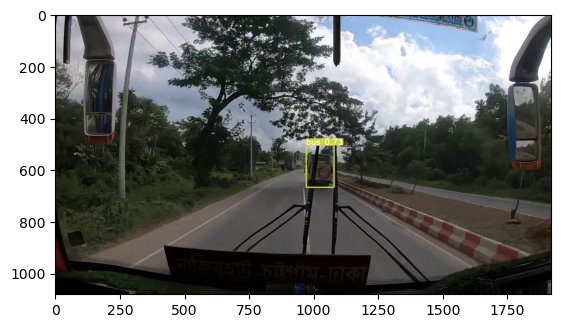

In [14]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

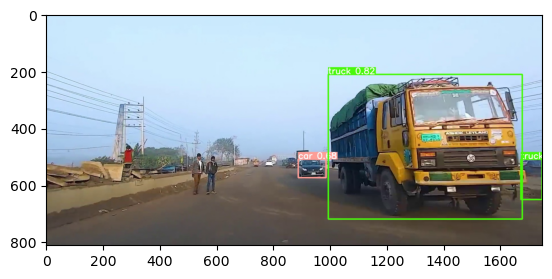

In [15]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

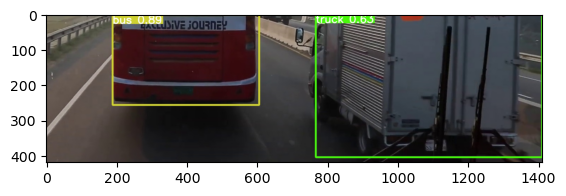

In [16]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

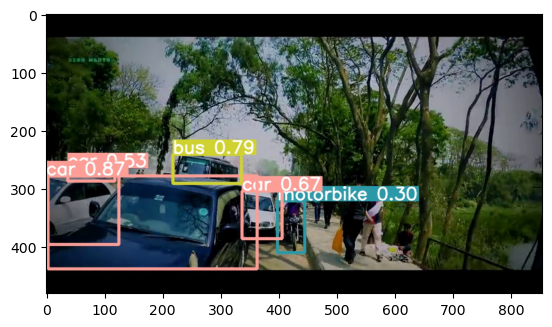

In [18]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

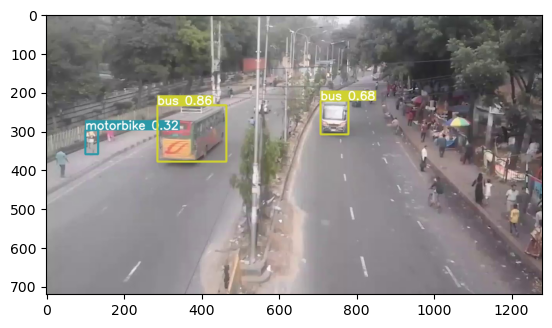

In [21]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

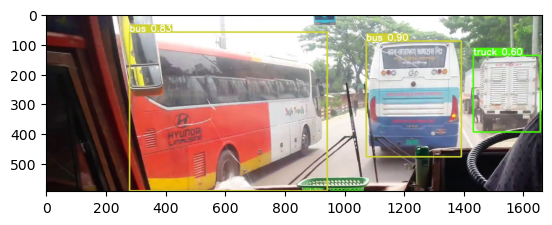

In [22]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

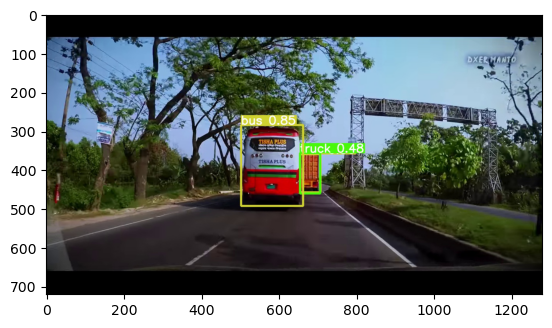

In [23]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

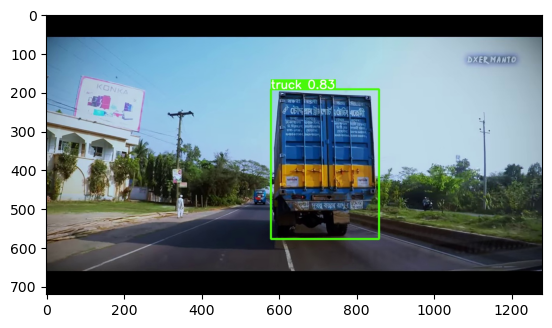

In [24]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

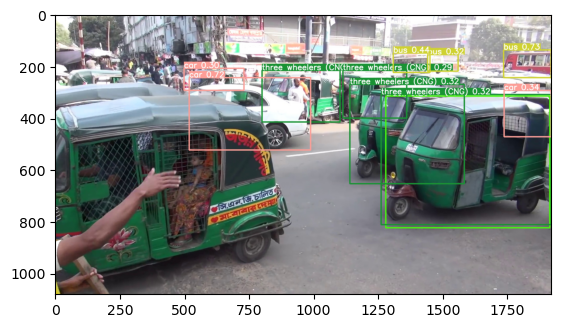

In [25]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

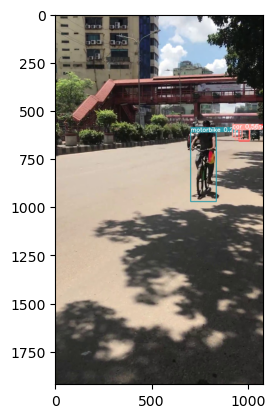

In [26]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

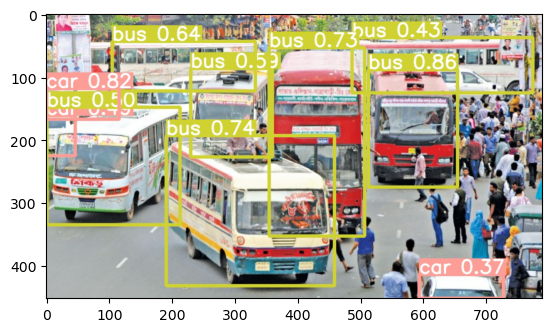

In [27]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

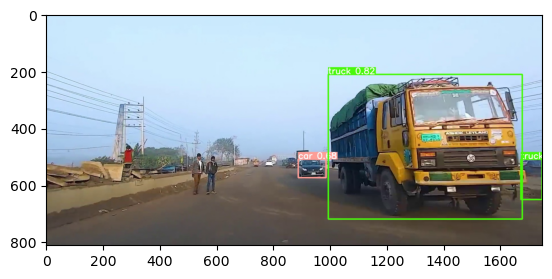

In [29]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

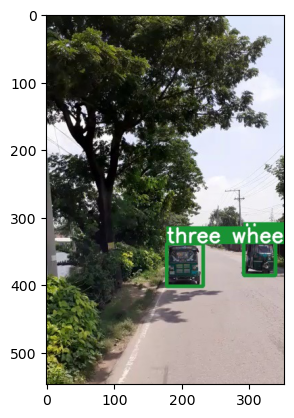

In [30]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

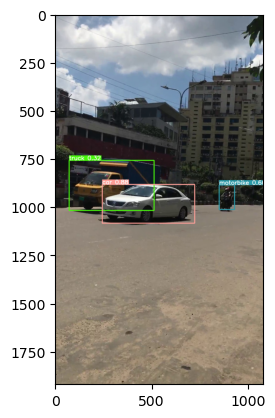

In [31]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

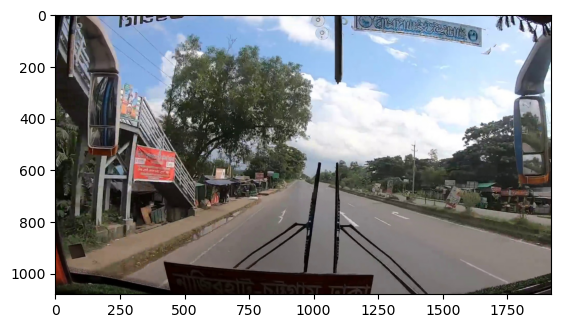

In [32]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

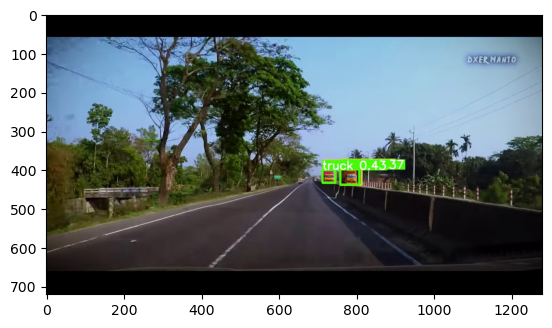

In [33]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

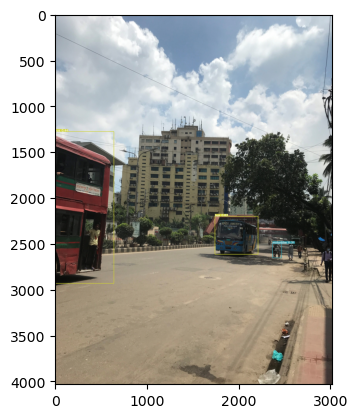

In [35]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

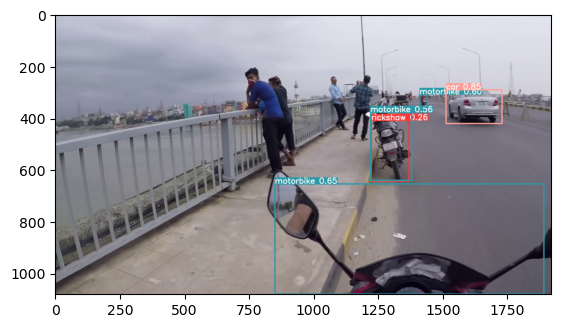

In [36]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

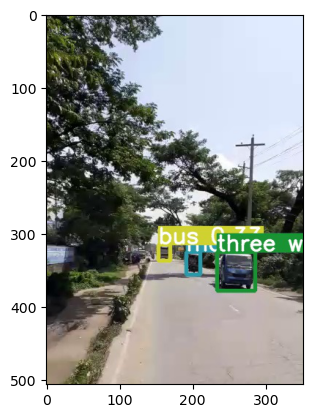

In [37]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

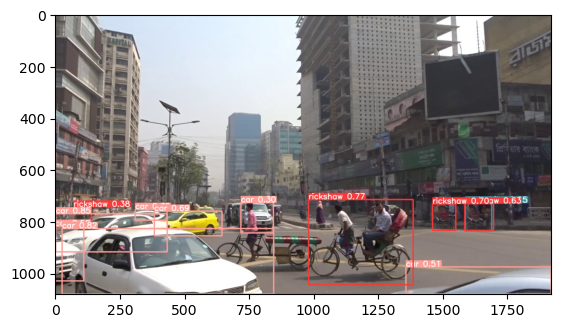

In [38]:
detections_dir = "/kaggle/working/yolov5/runs/detect/yolov5/VHC_detect4/"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

# Validation

In [39]:
!python /kaggle/working/yolov5/val.py --weights /kaggle/working/yolov5/runs/train/yolov5/vehicle_detect2/weights/best.pt --data /kaggle/input/vehicle-data-san/vehicle_data2.yaml --task test --name yolo_det

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
val: data=/kaggle/input/vehicle-data-san/vehicle_data2.yaml, weights=['/kaggle/working/yolov5/runs/train/yolov5/vehicle_detect2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=yolo_det, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-74-gd02ee60 Python-3.7.12 torch-1.12.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
YOLOv5s summary: 157 layers, 7066762 parameters, 0 gradients, 15.9 GFLOPs
test: Scanning /kaggle/working/vehicle-detection-dataset/labels/test.cache... 26
                 Class     Images  Instances          P          R      mAP50   
                   all        260       1652      0.835       0.18      0.209      0.127
              ricksh

In [ ]:
import shutil
shutil.make_archive('/kaggle/working/yolov5/runs/val/yolo_det','zip','/kaggle/input/vehicle-detection-dataset')

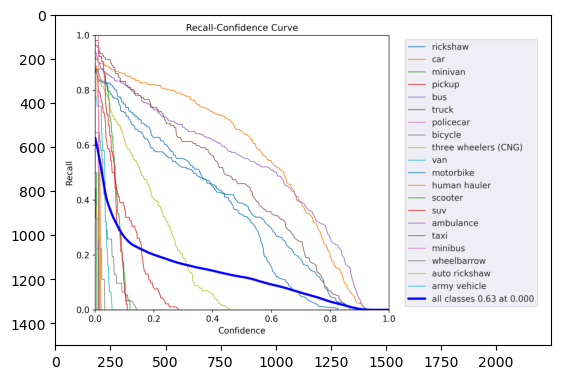

In [40]:
detections_dir = "/kaggle/working/yolov5/runs/val/yolo_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

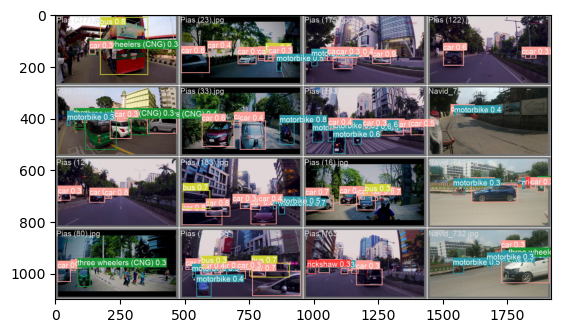

In [41]:
detections_dir = "/kaggle/working/yolov5/runs/val/yolo_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

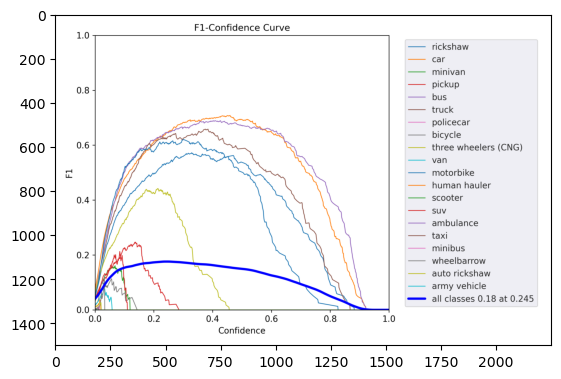

In [42]:
detections_dir = "/kaggle/working/yolov5/runs/val/yolo_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

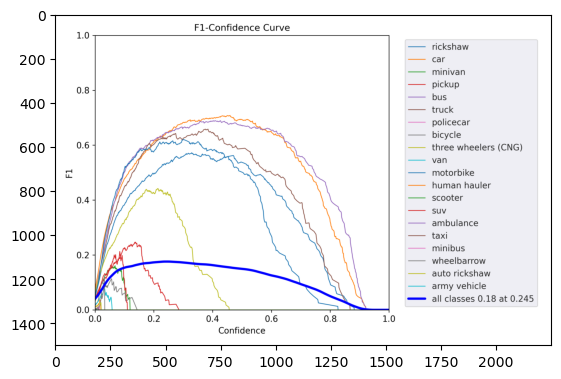

In [43]:
detections_dir = "/kaggle/working/yolov5/runs/val/yolo_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

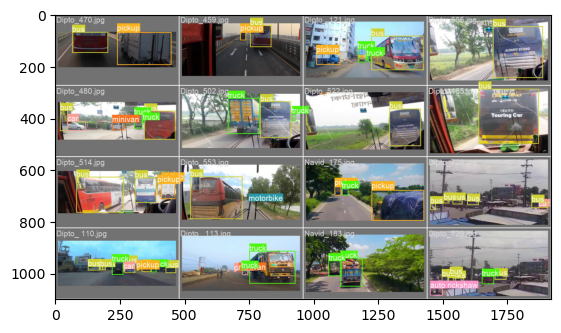

In [44]:
detections_dir = "/kaggle/working/yolov5/runs/val/yolo_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

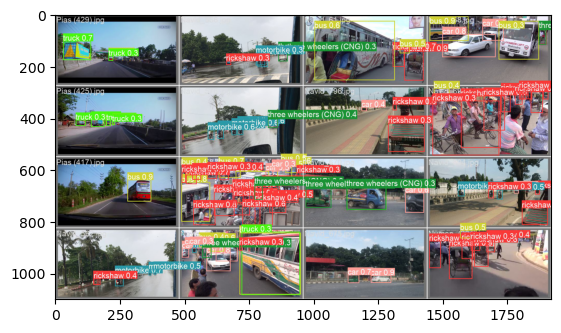

In [45]:
detections_dir = "/kaggle/working/yolov5/runs/val/yolo_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

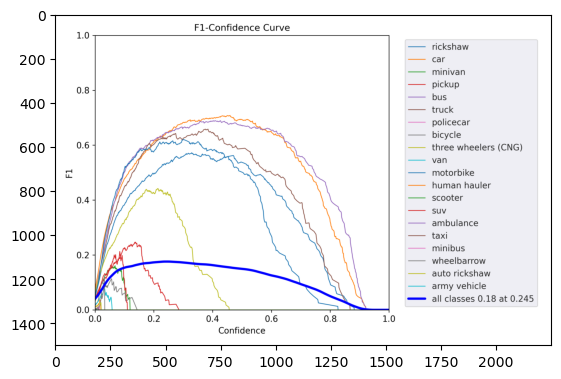

In [46]:
detections_dir = "/kaggle/working/yolov5/runs/val/yolo_det"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

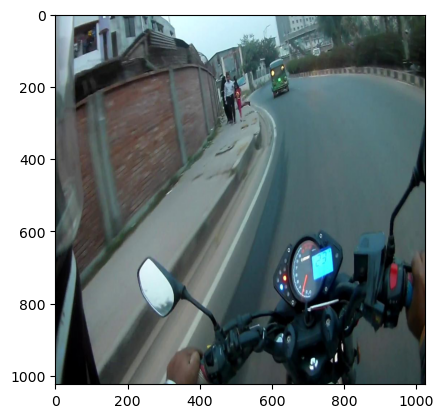

In [47]:
detections_dir = "/kaggle/input/vehicle-detection-dataset/test1/test"
detection_images = [os.path.join(detections_dir, x) for x in os.listdir(detections_dir)]

random_detection_image = Image.open(random.choice(detection_images))
plt.imshow(np.array(random_detection_image))

In [49]:
import os
os.chdir(r'/kaggle/working/vehicle-detection-dataset')

In [51]:
!cd /kaggle/working/

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
